In [1]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
import xgboost

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('../input/train_V2.csv', nrows=2000)
df_test  = pd.read_csv('../input/test_V2.csv', nrows=2000)

**Estatísticas descritivas que resumem a tendência central, a dispersão e a forma da distribuição de um conjunto de dados**

In [3]:
df_train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.246000,1.12400,130.800744,0.641500,0.221000,1.424500,47.779500,493.157000,0.926500,0.542500,21.813989,1572.618000,45.042500,43.510500,901.044000,0.15500,622.602729,0.004500,4.456669,0.026500,0.008000,1132.431257,3.620000,598.011000,0.473332
std,0.587926,1.73699,172.052861,1.128102,0.546176,2.744643,27.596697,619.896224,1.535994,0.703876,46.369431,258.757709,24.257512,23.661886,736.437335,0.44393,1509.812346,0.066948,30.238551,0.186588,0.089107,1148.878129,2.483482,737.226607,0.310775
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,492.000000,8.000000,1.000000,-1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,1366.000000,28.000000,27.000000,-1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,151.300000,2.000000,0.000000,0.204100
50%,0.000000,0.00000,82.030000,0.000000,0.000000,0.000000,47.000000,0.000000,0.000000,0.000000,0.000000,1435.000000,30.000000,30.000000,1447.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,676.100000,3.000000,0.000000,0.449400
75%,0.000000,2.00000,180.900000,1.000000,0.000000,2.000000,72.000000,1155.750000,1.000000,1.000000,20.025000,1845.000000,49.000000,47.000000,1500.000000,0.00000,150.450000,0.000000,0.000000,0.000000,0.000000,1918.500000,5.000000,1494.000000,0.750000
max,6.000000,11.00000,1750.000000,10.000000,6.000000,25.000000,99.000000,1850.000000,15.000000,4.000000,344.400000,2196.000000,100.000000,100.000000,2211.000000,3.00000,13510.000000,1.000000,534.500000,3.000000,1.000000,6755.000000,43.000000,1736.000000,1.000000


In [4]:
df_test.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
count,2000.000000,2000.00000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.249500,1.15050,134.810778,0.69950,0.239000,1.472000,46.906000,516.656500,0.980500,0.572000,23.655353,1569.386000,44.071000,42.509500,872.238500,0.158000,606.995601,0.002000,4.877073,0.021500,0.007500,1158.659976,3.566000,622.583500
std,0.591121,1.80568,170.565952,1.21117,0.630141,2.877039,27.596629,628.603357,1.578089,0.723932,51.020742,256.146982,23.275477,22.615407,737.717967,0.454025,1595.397846,0.054749,31.043072,0.158273,0.091913,1230.574566,2.325155,742.349752
min,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,599.000000,6.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,1363.750000,28.000000,27.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,137.700000,2.000000,0.000000
50%,0.000000,0.00000,89.930000,0.00000,0.000000,0.000000,46.000000,0.000000,0.000000,0.000000,0.000000,1432.000000,30.000000,30.000000,1429.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,641.450000,3.000000,0.000000
75%,0.000000,2.00000,194.150000,1.00000,0.000000,2.000000,71.000000,1165.500000,1.000000,1.000000,23.322500,1841.000000,49.000000,47.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1982.250000,5.000000,1495.250000
max,4.000000,13.00000,1503.000000,12.00000,6.000000,25.000000,99.000000,1999.000000,12.000000,4.000000,550.400000,2186.000000,100.000000,99.000000,2261.000000,4.000000,19000.000000,2.000000,557.800000,2.000000,2.000000,7076.000000,29.000000,1747.000000


**Retirando valores 'NaN'**

In [5]:
df_train = df_train.drop(df_train[df_train.winPlacePerc.isnull()].index,inplace = False)

**Calculando e exibindo heatmap da matriz de correlação do conjunto de treinamento**

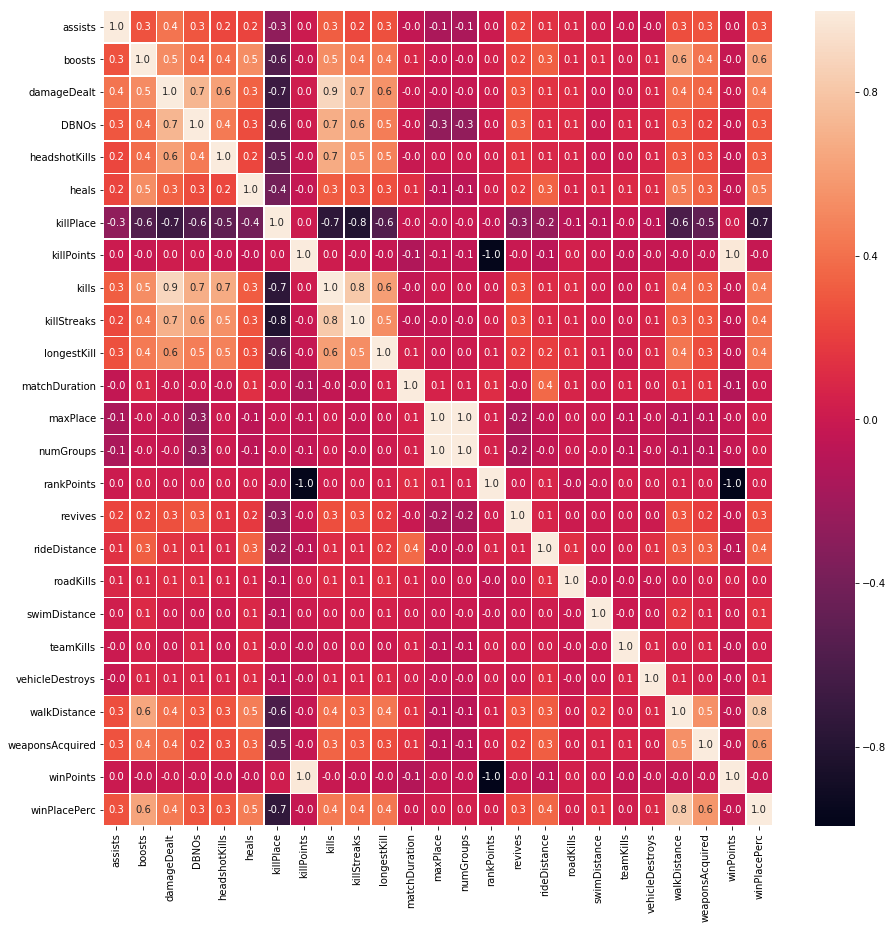

In [6]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, fmt='.1f',ax=ax)
plt.show()

**Obtendo as k variáveis com maiores correlações em relação ao alvo winPlacePerc**

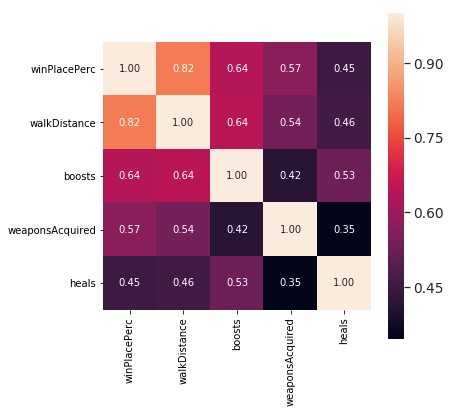

In [7]:
k = 5
f,ax = plt.subplots(figsize=(6, 6))
cm = df_train.corr().nlargest(k, 'winPlacePerc')
cols = cm.index
cm = cm[cols]
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Criando novas features, baseando-se nas correlações entre as variáveis**

In [8]:
def obter_features(df):
    #Obter a quantidade de jogadores por partida
    df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')

    #Obter taxa de mortes por jogador por partida
    df['killsPerMatch'] = df['kills'] / df['playersJoined']
    df['killsPerMatch'].fillna(0,inplace=True)

    #Obter taxa de dano por jogador por partida
    df['damagePerMatch'] = df['damageDealt'] / df['playersJoined']
    df['damagePerMatch'].fillna(0,inplace=True)

    #Obter quantidade média de dano por morte
    df['damagePerKill'] = df['damageDealt'] / df['kills']
    df['damagePerKill'].fillna(0,inplace=True)
    df['damagePerKill'].replace(np.inf,0,inplace=True)

    #Obter taxa de tiros na cabeça por morte
    df['headshotPerKill'] = df['headshotKills'] / df['kills']
    df['headshotPerKill'].fillna(0, inplace=True) 

    #Obter distância total percorrida pelo jogador na partida
    df['totalDistance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
    
    return df

In [9]:
df_train = obter_features(df_train)
df_test = obter_features(df_test)

In [10]:
features = df_train.columns
features = features.drop(['Id', 'groupId', 'matchId', 'winPlacePerc', 'matchType'])
features

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'playersJoined', 'killsPerMatch', 'damagePerMatch', 'damagePerKill',
       'headshotPerKill', 'totalDistance'],
      dtype='object')

**Mostrar as correlações das novas features em relação ao alvo (winPlacePerc)**

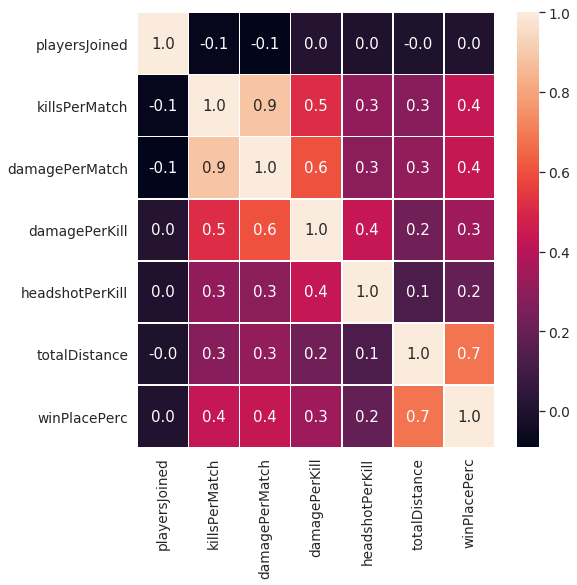

In [11]:
f,ax = plt.subplots(figsize=(8, 8))
new_features = df_train[['playersJoined', 'killsPerMatch', 'damagePerMatch', 'damagePerKill', 'headshotPerKill', 'totalDistance', 'winPlacePerc']]
sns.heatmap(new_features.corr(), annot=True, linewidths=.5, fmt='.1f',ax=ax)
plt.show()

**Transformação de Variáveis Categóricas em Numéricas**

*Verificar se matchType não vai precisar ser uma variável dummy*

In [12]:
#Separando a Classe das demais variáveis
target = df_train['winPlacePerc']
ids_train = df_train['Id']
ids_test = df_test['Id']
#Retirando também as variáveis winPlacePerc (alvo), Id, groupId e matchId
train_norm = np.array(df_train.drop(['Id', 'groupId', 'matchId', 'winPlacePerc', 'matchType'], axis=1))
test_norm = np.array(df_test.drop(['Id', 'groupId', 'matchId', 'matchType'], axis=1))

In [13]:
# from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# labelencoder_train = LabelEncoder()
# train_norm[:,12] = labelencoder_train.fit_transform(train_norm[:,12])
# onehotencoder = OneHotEncoder(categorical_features=[12])
# train_norm = onehotencoder.fit_transform(train_norm).toarray()

# labelencoder_test = LabelEncoder()
# test_norm[:,12] = labelencoder_test.fit_transform(test_norm[:,12])
# onehotencoder = OneHotEncoder(categorical_features=[12])
# test_norm = onehotencoder.fit_transform(test_norm).toarray()

**Normlizando usando o StandardScaler**

In [14]:
# #Normlizando usando o StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# train_norm = scaler.fit_transform(train_norm)
# #pd.DataFrame(train_norm).head()

# test_norm = scaler.fit_transform(test_norm)
train_norm = (train_norm-train_norm.min())/(train_norm.max()-train_norm.min())
test_norm = (test_norm-test_norm.min())/(test_norm.max()-test_norm.min())

In [15]:
train_norm.shape

(2000, 30)

}**Reduzir o uso de memória dos dados  **

In [16]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

train_norm = reduce_mem_usage(pd.DataFrame(train_norm))
target = reduce_mem_usage(pd.DataFrame(target))

test_norm = reduce_mem_usage(pd.DataFrame(test_norm))

Memory usage of dataframe is 480080.00 MB
Memory usage after optimization is: 120080.00 MB
Decreased by 75.0%
Memory usage of dataframe is 32000.00 MB
Memory usage after optimization is: 20000.00 MB
Decreased by 37.5%
Memory usage of dataframe is 480080.00 MB
Memory usage after optimization is: 120080.00 MB
Decreased by 75.0%


**Dividindo entre Treinamento(2/3) e Validação(1/3)**

In [17]:
#Salvar os Ids de cada instância para ter como associar depois do split
train_norm = train_norm.join(ids_train)

del ids_train

X_train, X_test, Y_train, Y_test = train_test_split(train_norm, target, test_size=1/3, random_state=0)
#pd.DataFrame(X_train).describe()


## ** Código para XGBoost **

**Separar os Ids dos conjuntos de treinamento e teste para que não afetem o modelo e que possam ser utilizados para submissão**

In [18]:
#Separar Ids dos conjuntos
ids_X_train = X_train['Id']
ids_X_test = X_test['Id']

X_train = X_train.drop(['Id'], axis=1)
X_test = X_test.drop(['Id'], axis=1)

**Treinando o modelo XGBoost Regressor**

In [19]:
#Treinando o modelo
model = xgboost.XGBRegressor(max_depth=17, gamma=0.3, learning_rate= 0.1)
model.fit(X_train,Y_train)

[13:23:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.3,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=17, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

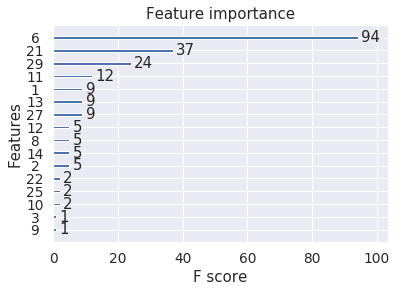

In [20]:
xgboost.plot_importance(model)

In [21]:
pred = model.predict(test_norm)

In [22]:
submit_xg = pd.DataFrame({'Id': ids_test, "winPlacePerc": pred} , columns=['Id', 'winPlacePerc'])

# r2_test_XGB = r2_score(Y_test,pred)
# mae_test_XGB = mean_absolute_error(Y_test,pred)

# print('XGBoost Resultados para o conjunto de testes:')
# print('Índice R^2: ' + str(r2_test_XGB))
# print('Erro médio absoluto: ' + str(mae_test_XGB))
print(submit_xg.head())
#submit_xg.to_csv("submission.csv", index = False)

               Id  winPlacePerc
0  9329eb41e215eb      0.420405
1  639bd0dcd7bda8      0.740850
2  63d5c8ef8dfe91      0.489908
3  cf5b81422591d1      0.690954
4  ee6a295187ba21      0.823394


## ***Código para Árvore de Decisão***

In [23]:
from sklearn.tree import DecisionTreeRegressor 
regressor = DecisionTreeRegressor()
regressor.fit(X_train,Y_train) #X são os previsores e Y os valores correspondentes
#Para fazer uma previsão:
previsoes = regressor.predict(X_test)

In [24]:
score_train_DT = regressor.score(X_train,Y_train) #Valor do score na base de dados de treinamento
score_test_DT = regressor.score(X_test,Y_test) #Valor do Score na base de dados de teste
acuracia_DT = r2_score(Y_test, previsoes)
print (score_train_DT)
print (score_test_DT)
print (acuracia_DT)


0.9999999914077328
0.7373262767872982
0.7373262767872982


**Calculando o Erro usando Mean Absolute Error**

In [25]:
#calculando o erro de uma árvore de decisão para regressão:
mae_DT = mean_absolute_error(Y_test,previsoes)
#mae contém o valor do mean absolute error
print (mae_DT)

0.10859541962112207


In [26]:
#f,ax = plt.subplots(figsize=(20, 20))
#sns.heatmap(df_train.corr(), annot=True, linewidths=.5, fmt='.1f',ax=ax)
#plt.show()


** Definir métrica de performance **

In [27]:
def performance_metric(y_true, y_predict):
    score = r2_score(y_true,y_predict)
    return score

**Converter o retorno do método sklearn.grid_search.GridSearchCV.grid_scores_ para um pandas DataFrame**

In [28]:
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to a tidy
    pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

## **Código para Random Forest**

** Treinamento do modelo **

In [29]:
# Gerar conjuntos de validação-cruzada para o treinamento de dados
cv_sets = ShuffleSplit(n_splits=5, test_size = 0.25)

#n_estimators =10
rfr =  RandomForestRegressor(n_estimators=10, random_state=42)

#Gerar um dicionário para o parâmetro 'max_depth' com um alcance de 1 a 10
params ={'max_depth': list(range(1,5))}

#Transformar 'performance_metric' em uma função de pontuação utilizando 'make_scorer' 
scoring_fnc = make_scorer(performance_metric)

# Gerar o objeto de busca em matriz
grid = GridSearchCV(rfr, params, scoring=scoring_fnc, cv=cv_sets)

# Ajustar o objeto de busca em matriz com os dados para calcular o modelo ótimo
grid = grid.fit(X_train, Y_train)

** Predição do modelo criado para o conjunto de teste **

In [30]:
# Usando o melhor modelo para predição
rfr = grid.best_estimator_
previsoes = rfr.predict(X_test)

*** Random Forest Regressor: Resultados obtidos ***

In [31]:
#Valor do score na base de dados de treinamento
score_train_RFR = rfr.score(X_train,Y_train)

#Valor do Score na base de dados de teste
score_test_RFR = rfr.score(X_test,Y_test)
print ('Random Forest Regressor Results: ')
print ('Score de treino: ' + str(score_train_RFR))
print ('Score de teste: ' + str(score_test_RFR))

#calculando o erro de uma árvore de decisão para regressão:
mae_RFR = mean_absolute_error(Y_test,previsoes)
#mae contém o valor do mean absolute error
print ('Erro médio absoluto: ' + str(mae_RFR))

#Acurácia do modelo
r2_RFR = r2_score(Y_test, previsoes)
print ('Índice R²: ' + str(r2_RFR))

Random Forest Regressor Results: 
Score de treino: 0.8640934805874937
Score de teste: 0.8430216963595155
Erro médio absoluto: 0.08753620436621125
Índice R²: 0.8430216963595155


In [32]:
rfr_scores = grid_scores_to_df(grid.grid_scores_)
rfr_scores

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

## **Código para um SVR**

In [33]:
from sklearn.svm import SVR

# Gerar conjuntos de validação-cruzada para o treinamento de dados
cv_sets = ShuffleSplit(n_splits=5, test_size = 0.25)

svr = SVR()

#Gerar um dicionário para o parâmetro 'max_depth' com um alcance de 1 a 10
params = {'kernel': ('rbf','linear','poly')}

#Transformar 'performance_metric' em uma função de pontuação utilizando 'make_scorer' 
scoring_fnc = make_scorer(performance_metric)

# Gerar o objeto de busca em matriz
grid = GridSearchCV(svr, params, scoring=scoring_fnc, cv=cv_sets)

# Ajustar o objeto de busca em matriz com os dados para calcular o modelo ótimo
grid = grid.fit(X_train, Y_train)

** Predição do modelo criado para o conjunto de teste **

In [34]:
# Usando o melhor modelo para predição
svr = grid.best_estimator_
previsoes = svr.predict(X_test)

*** SVR: Resultados obtidos ***

In [35]:
#Valor do score na base de dados de treinamento
score_train_SVR = svr.score(X_train,Y_train)

#Valor do Score na base de dados de teste
score_test_SVR = svr.score(X_test,Y_test)
print ('SVR Results: ')
print ('Score de treino: ' + str(score_train_SVR))
print ('Score de teste: ' + str(score_test_SVR))

#calculando o erro de uma árvore de decisão para regressão:
mae_SVR = mean_absolute_error(Y_test,previsoes)
#mae contém o valor do mean absolute error
print ('Erro médio absoluto: ' + str(mae_SVR))

#Acurácia do modelo
r2_SVR = r2_score(Y_test, previsoes)
print ('Índice R²: ' + str(r2_SVR))

SVR Results: 
Score de treino: 0.7196883863624823
Score de teste: 0.7075580271084545
Erro médio absoluto: 0.12837627083382763
Índice R²: 0.7075580271084545


In [36]:
svr_scores = grid_scores_to_df(grid.grid_scores_)
svr_scores

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'